## EIG Stats

In [59]:
import os
import json
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

RUN_ID = 'run_combined'

# Path to search for captain.json files
base_path = f'/home/ubuntu/new_battleship/battleship/experiments/collaborative/captain_benchmarks/run_4o_llmdecision_captain/'

# Find all captain.json files in subdirectories
captain_files = glob.glob(os.path.join(base_path, '**/captain/captain.json'), recursive=True)

# Dictionary to store eig values by file
eig_values_by_file = {}
# Initialize list to store data for DataFrame
eig_data_list = []

# Extract eig values from each file
for file_path in captain_files:
    # Get relative path for naming
    rel_path = os.path.relpath(file_path, base_path)
    
    # Extract round_id from path
    # Use regex to extract the part after 'round_' in the relative path
    match = re.search(r'round_([a-zA-Z0-9]+)', rel_path)
    round_id = match.group(1) if match else None
    
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
        # Extract eig values, skipping None/null values
        for idx, datum in enumerate(data):
            if 'eig' in datum and datum['eig'] is not None and 'question' in datum and datum['question'] is not None:
                question_text = datum['question']['question']['text'] if datum['question']['question'] and 'text' in datum['question']['question'] else "No question text"
                eig_value = datum['eig']
                
                eig_questions = datum.get("eig_questions", [])


                if eig_questions is not None:
                    if len(eig_questions) != 0:
                        eig_questions = [(q['question']['question']['text'],q['eig'], None) for q in eig_questions]
                        max_eig = max([eq[1] for eq in eig_questions if eq[1] is not None])
                        eig_questions = [(q[0], q[1], q[1] == max_eig) for q in eig_questions]

                # Add to data list
                eig_data_list.append({
                    'round_id': round_id,
                    'question_idx': idx,
                    'question': question_text,
                    'eig': eig_value,
                    'eig_questions': eig_questions,
                })
                
    except (json.JSONDecodeError, FileNotFoundError, KeyError, TypeError) as e:
        print(f"Error processing {file_path}: {e}")

# Create DataFrame from the list
eig_df = pd.DataFrame(eig_data_list)

In [12]:
eig_df

,round_id,question_idx,question,eig,eig_questions
0,c05cc517,1,Is there at least one part of any ship in Row D?,0.648472,None
1,c05cc517,3,Is there at least one part of any ship in Row E?,0.657705,None
2,c05cc517,5,Is there at least one part of any ship in Row F?,0.750932,None
3,c05cc517,11,Is there at least one part of any ship in Colu...,0.811278,None
4,c05cc517,21,Is there at least one part of any ship in Row A?,0.972678,None
...,...,...,...,...,...
1461,b9fa5dfc,57,Is there any part of a ship in row G?,0.599739,None
1462,b9fa5dfc,69,Is there any part of a ship in column 7?,0.909736,None
1463,b9fa5dfc,75,Is there any part of a ship in column 8?,0.969769,None
1464,b9fa5dfc,85,Is there any part of a ship in row H?,0.962836,None


In [27]:
import json
import os
import pandas as pd
def extract_questions_and_boards_to_dataframe(json_path):
    """
    Extracts all questions asked and the board state at the time they were asked from a JSON file
    and returns the data as a pandas DataFrame.

    Args:
        json_path (str): Path to the input JSON file.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted questions and board states.
    """
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"The file {json_path} does not exist.")

    with open(json_path, 'r') as f:
        data = json.load(f)

    extracted_data = []

    for entry in data:
        if "question" in entry and "occTiles" in entry:
            question = entry["question"]
            program = entry["program"]
            board_state = entry["occTiles"]
            answer = entry["answer"]
            true_answer = entry["true_answer"]

            if answer.lower() == "true":
                answer = "yes"
            if answer.lower() == "false":
                answer = "no"

            extracted_data.append({
                "question": question,
                "program": program,
                "board_state": board_state,
                "answer": answer,
                "true_answer": true_answer,
                "correct": answer == true_answer
            })

    return pd.DataFrame(extracted_data)

# Example usage:
# Provide the path to the input JSON file
input_json_path = "/home/ubuntu/new_battleship/battleship/experiments/collaborative/spotter_benchmarks/o4-mini_CodeSpotterModel_True.json"
output_df = extract_questions_and_boards_to_dataframe(input_json_path)
output_df = output_df[output_df['correct'] == True]
output_df

,question,program,board_state,answer,true_answer,correct
0,is there a ship longer than 3 tiles,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,yes,True
1,Is there a horizantal ship on G or H,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,2,-1,-1,-1,-...",yes,yes,True
2,Is the a horizantal dhip after G5 OR H5,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,2,-1,-1,-1,-...",no,no,True
3,Is the final ship below G,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,0,-1,-1],[-1,0,2,-1,-1,-1,0,-...",no,no,True
4,Is it above c,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,0,-1,-1],[-1,0,2,-1,-1,-1,0,-...",no,no,True
...,...,...,...,...,...,...
943,Is there a piece of the red ship in letter C?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,4,4,4,4,4,0,-1],[-1,0,-1,0,2,-1,0,-1],[-1...",yes,yes,True
944,Is the red ship vertical?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,0,-1,0,3,3,3,-1],[0,0,0,-1,0,-1,0,0],[0,-...",no,no,True
945,Is the orange ship horizontal?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,0,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,0...",yes,yes,True
946,Is the purple ship horizontal?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,yes,True


In [53]:
from battleship.agents import EIGCalculator, CodeQuestion, Question
from battleship.game import Board
import ast

eig_calculator = EIGCalculator(samples=1000, timeout=15)

# Add a new column to store EIG values
output_df["calculated_eig"] = None

for idx, row in output_df.iterrows():
        # Create a CodeQuestion instance

        l = ast.literal_eval(row["board_state"])

        code_question = CodeQuestion(
            question=Question(row["question"]),
            fn_text=row["program"],
            translation_prompt="",
            completion={}
        )

        # Convert board_state to a Board instance
        board_state = np.array(l)
        board = Board(board=board_state)

        # Calculate EIG
        eig_value = eig_calculator(code_question, board)
        output_df.at[idx, "calculated_eig"] = eig_value
        print(f"Processed row {idx+1}/{len(output_df)}: EIG = {eig_value}")

Processed row 1/886: EIG = 0.6073321363584707
Processed row 2/886: EIG = 0.989236669894531
Processed row 3/886: EIG = 0.996257296837527
Processed row 4/886: EIG = 0.6484721588056495
Processed row 5/886: EIG = 0.9054656073736549
Processed row 6/886: EIG = 0.9032906780348728
Processed row 7/886: EIG = 0.7933733558484892
Processed row 8/886: EIG = 0.9999278640456613
Processed row 10/886: EIG = 0.9228919718923301
Processed row 11/886: EIG = 0.6756821861637246
Processed row 12/886: EIG = 0.5709929600768895
Processed row 13/886: EIG = 0.6800770457282805
Processed row 14/886: EIG = 0.8414646362081744
Processed row 15/886: EIG = 0.954434002924966
Processed row 16/886: EIG = 0.9785531675659289
Processed row 17/886: EIG = 0.6622595460438845
Processed row 18/886: EIG = 0.7866261099705998
Processed row 19/886: EIG = 0.1842605933396566
Processed row 20/886: EIG = 0.6197604376555947
Processed row 21/886: EIG = 0.9732424074349115
Processed row 22/886: EIG = 0.7527960664084556
Processed row 23/886: EI

KeyboardInterrupt: 

In [54]:
output_df

,question,program,board_state,answer,true_answer,correct,calculated_eig
0,is there a ship longer than 3 tiles,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,yes,True,0.607332
1,Is there a horizantal ship on G or H,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,2,-1,-1,-1,-...",yes,yes,True,0.989237
2,Is the a horizantal dhip after G5 OR H5,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,2,-1,-1,-1,-...",no,no,True,0.996257
3,Is the final ship below G,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,0,-1,-1],[-1,0,2,-1,-1,-1,0,-...",no,no,True,0.648472
4,Is it above c,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,0,-1,-1],[-1,0,2,-1,-1,-1,0,-...",no,no,True,0.905466
...,...,...,...,...,...,...,...
943,Is there a piece of the red ship in letter C?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,4,4,4,4,4,0,-1],[-1,0,-1,0,2,-1,0,-1],[-1...",yes,yes,True,None
944,Is the red ship vertical?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,0,-1,0,3,3,3,-1],[0,0,0,-1,0,-1,0,0],[0,-...",no,no,True,None
945,Is the orange ship horizontal?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,0,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,0...",yes,yes,True,None
946,Is the purple ship horizontal?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,yes,True,None


In [56]:
# Create a new dataframe where each row contains a round_id and a question from eig_questions
expanded_df = []

for _, row in eig_df.iterrows():
    # Only process rows that have eig_questions
    if row['eig_questions'] and len(row['eig_questions']) > 0:
        for question, eig_value, is_max in row['eig_questions']:
            expanded_df.append({
                'round_id': row['round_id'],
                'parent_question': row['question'],
                'parent_eig': row['eig'],
                'candidate_question': question,
                'candidate_eig': eig_value,
                'is_max_eig': is_max
            })

# Create the dataframe
eig_questions_df = pd.DataFrame(expanded_df)

# Display the first few rows
eig_questions_df

""


/tmp/ipykernel_2775/992720527.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Source', y='EIG Values', palette='Set2')


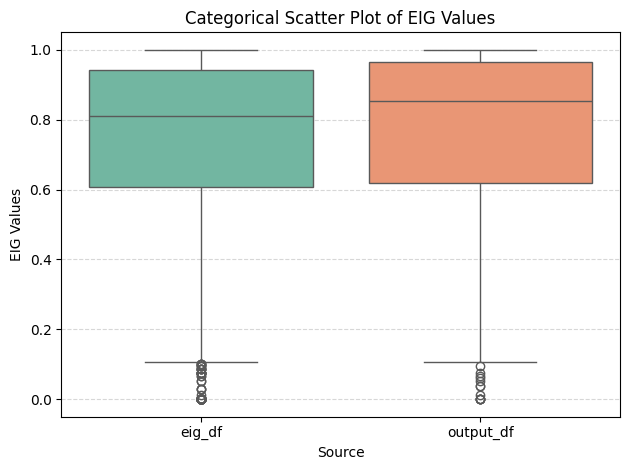

Average EIG for eig_df: 0.7153
Average EIG for output_df: 0.7403


In [60]:
import seaborn as sns

import matplotlib.pyplot as plt

# Prepare the data for plotting
plot_data = pd.DataFrame({
    'EIG Values': pd.concat([eig_df["eig"], output_df["calculated_eig"]], ignore_index=True),
    'Source': ['eig_df'] * len(eig_df) + ['output_df'] * len(output_df)
})

# Create a boxplot instead of a scatter plot
sns.boxplot(data=plot_data, x='Source', y='EIG Values', palette='Set2')

# Add labels and title
plt.title('Categorical Scatter Plot of EIG Values')
plt.xlabel('Source')
plt.ylabel('EIG Values')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Calculate and print the average EIG values for both distributions
avg_eig_df = eig_df["eig"].mean()
avg_output_df = output_df["calculated_eig"].astype(float).mean()

print(f"Average EIG for eig_df: {avg_eig_df:.4f}")
print(f"Average EIG for output_df: {avg_output_df:.4f}")

In [ ]:

# Function to find and process result files
def process_result_files():
    # Construct path to results directory
    results_path = f'/home/ubuntu/new_battleship/battleship/experiments/collaborative/captain_benchmarks/{RUN_ID}/results/'
    
    # Find all result JSON files
    result_files = glob.glob(os.path.join(results_path, '*.json'))
    
    # List to store results
    results_data = []
    
    # Process each result file
    for file_path in result_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                
                # Each file might contain a list of results
                for item in data:
                    results_data.append(item)
        except (json.JSONDecodeError, FileNotFoundError) as e:
            print(f"Error processing {file_path}: {e}")
    
    # Create DataFrame
    df_results = pd.DataFrame(results_data)
    
    # Extract round_id from file names in eig_values_by_file
    eig_data = []
    for file_name in eig_values_by_file:
        # Extract round_id from the path (format: round_XXXXXXXX/captain/captain.json)
        round_id = file_name.split('/')[0].split('_')[1]
        
        # Calculate statistics for EIG values
        values = eig_values_by_file[file_name]
        eig_data.append({
            'round_id': round_id,
            'eig_count': len(values),
            'eig_min': min(values),
            'eig_max': max(values),
            'eig_avg': sum(values)/len(values),
            'eig_median': np.median(values)
        })
    
    # Create DataFrame with EIG statistics
    df_eig = pd.DataFrame(eig_data)
    
    # Merge the results and EIG DataFrames on round_id
    df_combined = pd.merge(df_results, df_eig, on='round_id', how='left')
    
    return df_combined

# Process the result files and create DataFrame
df_combined = process_result_files()

# Display the combined DataFrame
print(f"Combined DataFrame shape: {df_combined.shape}")
df_combined

In [ ]:
# Merge eig_df with df_combined to get captain_type for each question
merged_df = pd.merge(eig_df, df_combined[['round_id', 'captain_type', 'board_id']], on='round_id', how='inner')

# Sort the dataframe by captain_type and round_id for better organization
merged_df = merged_df.sort_values(by=['captain_type', 'round_id', 'question_idx'])

# Display the first few rows to verify the merge
print(f"Merged DataFrame shape: {merged_df.shape}")
merged_df

In [ ]:
# Create a boxplot of EIG values divided by captain type
plt.figure(figsize=(12, 6))

# Filter out any remaining EIG values over 1 (additional safety check)
filtered_merged_df = merged_df[merged_df['eig'] <= 1]

# Get all unique captain types from filtered data
captain_types = filtered_merged_df['captain_type'].unique()
n_types = len(captain_types)

# Prepare data for boxplot
box_data = []
colors = plt.cm.Set1(np.linspace(0, 1, n_types))  # Generate colors for each captain type

for captain_type in captain_types:
    captain_data = filtered_merged_df[filtered_merged_df['captain_type'] == captain_type]['eig']
    box_data.append(captain_data)

# Create boxplot
box = plt.boxplot(box_data, positions=range(n_types), widths=0.6, patch_artist=True)

# Color the boxes
for i, (patch, color) in enumerate(zip(box['boxes'], colors)):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize plot
plt.ylabel('EIG Value')
plt.title('EIG Values by Captain Type')
plt.xticks(range(n_types), captain_types, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add sample size information
for i, captain_type in enumerate(captain_types):
    n_samples = len(filtered_merged_df[filtered_merged_df['captain_type'] == captain_type])
    plt.text(i, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), 
             f'n={n_samples}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Precision/Recall Stats

In [58]:
from battleship.run_captain_benchmarks import rebuild_captain_summary_from_results
from battleship.utils import resolve_project_path
import pandas as pd
import numpy as np

In [59]:
# ////////////////////////////////////////////////////
# This cell defines all the paths for graph generation
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

# We expect human round data to be in the battleship-final-data directory from the Drive
human_round_data_path = resolve_project_path("experiments/collaborative/battleship-final-data/round.csv")

# We expect model round data to be in a 'captain_benchmarks' subdirectory of the collaborative experiments directory
model_round_data_unresolved_paths = [
    ('4o', 'experiments/collaborative/captain_benchmarks/run_4o_eig_captain'),
    ('4o','experiments/collaborative/captain_benchmarks/run_4o_llmdecision_captain'),
    ('4o','experiments/collaborative/captain_benchmarks/run_4o_mapeig_cot_captain'),
    ('4o','experiments/collaborative/captain_benchmarks/run_4o_mapeig_no_cot_captain'),
    ('llama_4_scout','experiments/collaborative/captain_benchmarks/run_llama_4_scout_eigcaptain'),
    ('llama_4_scout','experiments/collaborative/captain_benchmarks/run_llama_4_scout_llmdecision_captain'),
    ('llama_4_scout','experiments/collaborative/captain_benchmarks/run_llama_4_scout_mapeig'),
    ('o4-mini','experiments/collaborative/captain_benchmarks/run_o4-mini_eig_captains'),
    ('o4-mini','experiments/collaborative/captain_benchmarks/run_o4-mini_mapeig_no_cot_captain'),
    ('o4-mini','experiments/collaborative/captain_benchmarks/run_o4-mini_more_seeds'),
    ('o4-mini','experiments/collaborative/captain_benchmarks/run_o4-mini_random_map_llmdecision_captains'),
]

model_round_data_paths = [(name, resolve_project_path(path)) for name, path in model_round_data_unresolved_paths]


In [60]:
# ////////////////////////////////////////////////////
# This cell processes the human round data 
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

import os
import ast

MAX_QUESTIONS = 15

# Load the CSV file containing round data

# Define the path to the CSV file
round_df = pd.read_csv(human_round_data_path)
# Ensure occTiles and trueTiles are parsed as lists of lists if they are stored as strings

def parse_tiles(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except Exception:
            return []
    return val

round_df['occTiles'] = round_df['occTiles'].apply(parse_tiles)
round_df['trueTiles'] = round_df['trueTiles'].apply(parse_tiles)

def count_revealed_and_total(occ_tiles, true_tiles):
    # Flatten the lists in case they are 2D
    occ_flat = [item for sublist in occ_tiles for item in sublist] if occ_tiles else []
    true_flat = [item for sublist in true_tiles for item in sublist] if true_tiles else []
    # Total revealed: count of values in occTiles that are not -1
    total_revealed = sum(1 for v in occ_flat if v != -1)
    # True tiles: indices where trueTiles is not 0
    true_indices = set(i for i, v in enumerate(true_flat) if v != 0)
    # Revealed true tiles: those indices where occTiles is not -1 and trueTiles is not 0
    revealed_true = sum(1 for i in true_indices if i < len(occ_flat) and occ_flat[i] != -1)
    return pd.Series({'total_revealed': total_revealed, 'revealed_true': revealed_true, 'true_indices': true_indices})

round_df[['total_revealed', 'revealed_true', 'true_indices']] = round_df.apply(
    lambda row: count_revealed_and_total(row['occTiles'], row['trueTiles']), axis=1
)

round_df = round_df.assign(
    captain_type='human',
    spotter_type='human',
    round_id=round_df['id'],
    seed='human',
    hits=round_df['revealed_true'],
    misses=round_df['total_revealed'] - round_df['revealed_true'],
    question_count=MAX_QUESTIONS - round_df['questionsRemaining'],
    precision=lambda df: round_df['revealed_true'] / round_df['total_revealed'],
    recall=lambda df: round_df['revealed_true'] / round_df['true_indices'].apply(len),
    f1_score=lambda df: 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall']).replace(0, np.nan),
    is_won=lambda df: df['recall'] == 1,
    llm='human'
)[[
    'captain_type', 'spotter_type', 'round_id', 'board_id', 'seed', 'hits', 
    'misses', 'is_won', 'question_count', 'precision', 'recall', 'f1_score', "llm"
]]

round_df

,captain_type,spotter_type,round_id,board_id,seed,hits,misses,is_won,question_count,precision,recall,f1_score,llm
0,human,human,01JDMZVSGBA3PJBC5AY3SB613R,B03,human,13,17,True,13,0.433333,1.0,0.604651,human
1,human,human,01JDN0VKDN87TVWWHBYDJBY8NR,B16,human,18,11,True,8,0.620690,1.0,0.765957,human
2,human,human,01JDN1QKG7D7E8AEDEMJBX4758,B10,human,9,22,True,13,0.290323,1.0,0.450000,human
3,human,human,01JDN2F3NG0TPHBF7CQ4BSEJZ5,B14,human,15,17,True,6,0.468750,1.0,0.638298,human
4,human,human,01JDN32SA1YJMXY3MYS8TRHFEF,B02,human,12,9,True,15,0.571429,1.0,0.727273,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,human,human,01JJZ4GATW03WJS39WVN0S87EY,B17,human,13,9,True,1,0.590909,1.0,0.742857,human
122,human,human,01JJZ4PE7A3F1K85AZ7SK4AKBS,B04,human,13,18,True,2,0.419355,1.0,0.590909,human
123,human,human,01JJZ4ZY4T4E01TV5H8BAAPAF3,B16,human,18,18,True,2,0.500000,1.0,0.666667,human
124,human,human,01JJZ58JHCAYV885N5T0TD9MW7,B06,human,10,27,True,2,0.270270,1.0,0.425532,human


In [61]:
# ////////////////////////////////////////////////////
# This cell processes the model round data
# \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

dfs = []
for name, path in model_round_data_paths:
    df = pd.DataFrame(rebuild_captain_summary_from_results(path))
    df['llm'] = name
    dfs.append(df)

summary_df = pd.concat(dfs, ignore_index=True)
summary_df

,captain_type,spotter_type,round_id,board_id,seed,hits,misses,is_won,question_count,precision,recall,f1_score,llm
0,EIGCaptain_cot,Spotter,5a37193c,B02,111.0,7.0,33.0,False,15.0,0.175000,0.583333,0.269231,4o
1,EIGCaptain,Spotter,c34014f4,B06,42.0,10.0,9.0,True,15.0,0.526316,1.000000,0.689655,4o
2,EIGCaptain,Spotter,85c22953,B11,42.0,12.0,28.0,False,15.0,0.300000,0.800000,0.436364,4o
3,EIGCaptain,Spotter,36e8de28,B04,111.0,11.0,29.0,False,15.0,0.275000,0.846154,0.415094,4o
4,EIGCaptain_cot,Spotter,46260b7d,B12,42.0,9.0,17.0,True,15.0,0.346154,1.000000,0.514286,4o
...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,RandomCaptain,Spotter,81d80b55,B09,42.0,7.0,33.0,False,0.0,0.175000,0.466667,0.254545,o4-mini
752,RandomCaptain,Spotter,5dcf65b2,B16,42.0,11.0,29.0,False,0.0,0.275000,0.611111,0.379310,o4-mini
753,MAPCaptain,Spotter,4d6203e0,B18,42.0,11.0,18.0,True,0.0,0.379310,1.000000,0.550000,o4-mini
754,RandomCaptain,Spotter,f88fa1af,B17,42.0,8.0,32.0,False,0.0,0.200000,0.615385,0.301887,o4-mini


In [62]:
# Align the columns of summary_df with round_df
aligned_summary_df = summary_df[round_df.columns]

# Append summary_df to round_df
combined_df = pd.concat([round_df, aligned_summary_df], ignore_index=True)

# Display the shape of the combined DataFrame
combined_df = combined_df[(combined_df['hits'] + combined_df['misses']) <= 40]
combined_df

,captain_type,spotter_type,round_id,board_id,seed,hits,misses,is_won,question_count,precision,recall,f1_score,llm
0,human,human,01JDMZVSGBA3PJBC5AY3SB613R,B03,human,13.0,17.0,True,13.0,0.433333,1.000000,0.604651,human
1,human,human,01JDN0VKDN87TVWWHBYDJBY8NR,B16,human,18.0,11.0,True,8.0,0.620690,1.000000,0.765957,human
2,human,human,01JDN1QKG7D7E8AEDEMJBX4758,B10,human,9.0,22.0,True,13.0,0.290323,1.000000,0.450000,human
3,human,human,01JDN2F3NG0TPHBF7CQ4BSEJZ5,B14,human,15.0,17.0,True,6.0,0.468750,1.000000,0.638298,human
4,human,human,01JDN32SA1YJMXY3MYS8TRHFEF,B02,human,12.0,9.0,True,15.0,0.571429,1.000000,0.727273,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,RandomCaptain,Spotter,81d80b55,B09,42.0,7.0,33.0,False,0.0,0.175000,0.466667,0.254545,o4-mini
878,RandomCaptain,Spotter,5dcf65b2,B16,42.0,11.0,29.0,False,0.0,0.275000,0.611111,0.379310,o4-mini
879,MAPCaptain,Spotter,4d6203e0,B18,42.0,11.0,18.0,True,0.0,0.379310,1.000000,0.550000,o4-mini
880,RandomCaptain,Spotter,f88fa1af,B17,42.0,8.0,32.0,False,0.0,0.200000,0.615385,0.301887,o4-mini


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'human'),
  Text(1, 0, 'EIGCaptain_cot'),
  Text(2, 0, 'EIGCaptain'),
  Text(3, 0, 'LLMDecisionCaptain_cot'),
  Text(4, 0, 'LLMDecisionCaptain'),
  Text(5, 0, 'MAPEIGCaptain_cot'),
  Text(6, 0, 'MAPEIGCaptain'),
  Text(7, 0, 'RandomCaptain'),
  Text(8, 0, 'MAPCaptain')])

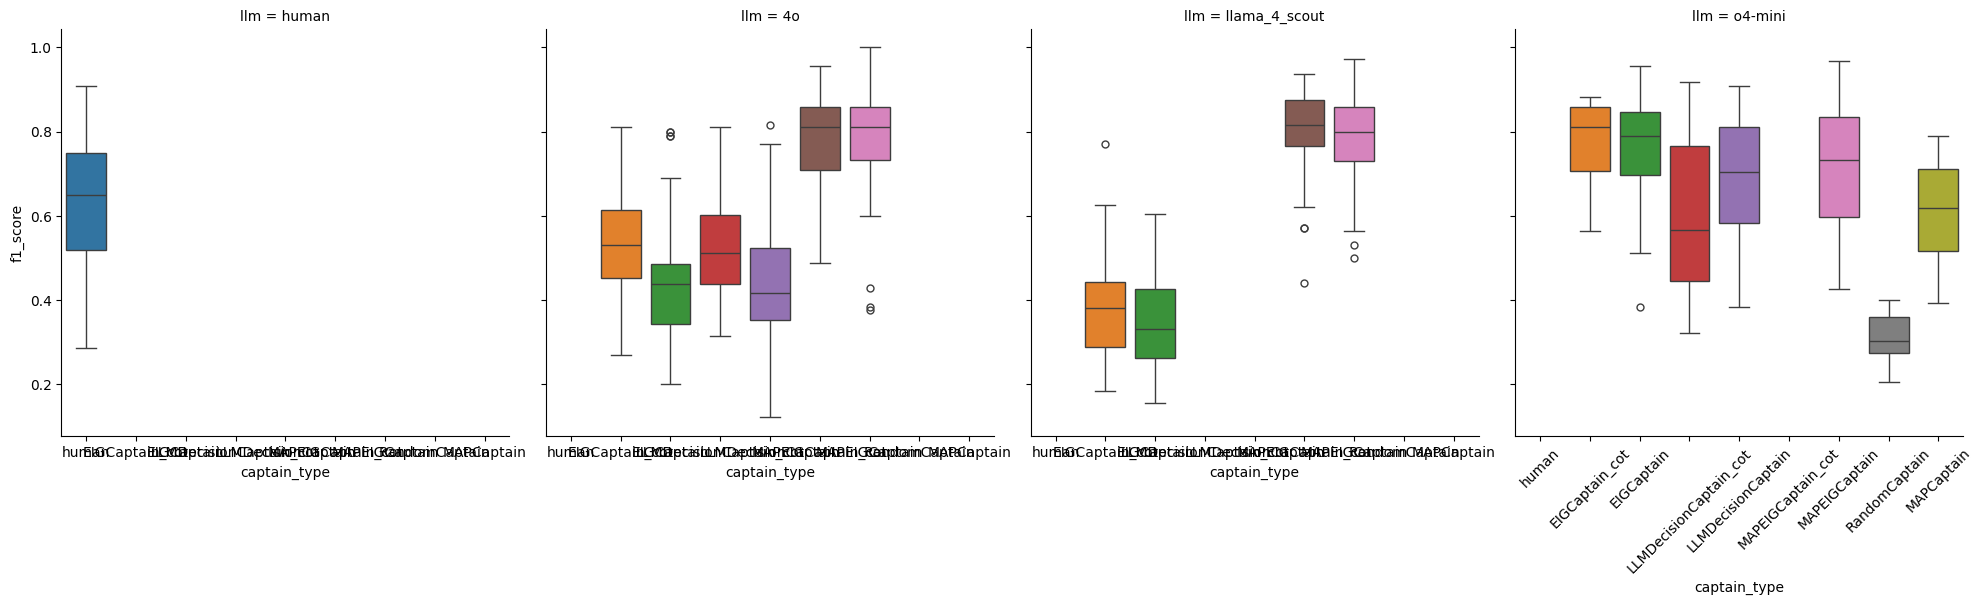

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=combined_df, kind="box", col="llm", x="captain_type", y="f1_score", hue="captain_type")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'EIGCaptain'),
  Text(1, 0, 'LLMDecisionCaptain'),
  Text(2, 0, 'MAPCaptain'),
  Text(3, 0, 'MAPEIGCaptain'),
  Text(4, 0, 'RandomCaptain'),
  Text(5, 0, 'human')])

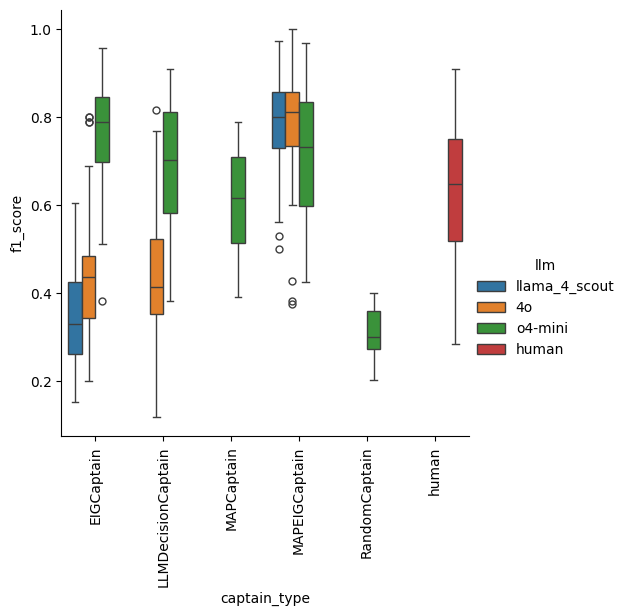

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sorted_df = combined_df.sort_values(by='captain_type', ascending=True)
sorted_df = sorted_df[sorted_df['captain_type'].isin(['human', 'RandomCaptain', 'MAPCaptain','LLMDecisionCaptain', 'EIGCaptain', 'MAPEIGCaptain'])]  

sns.catplot(data=sorted_df, kind="box", x="captain_type", y="f1_score", hue="llm")

plt.xticks(rotation=90)

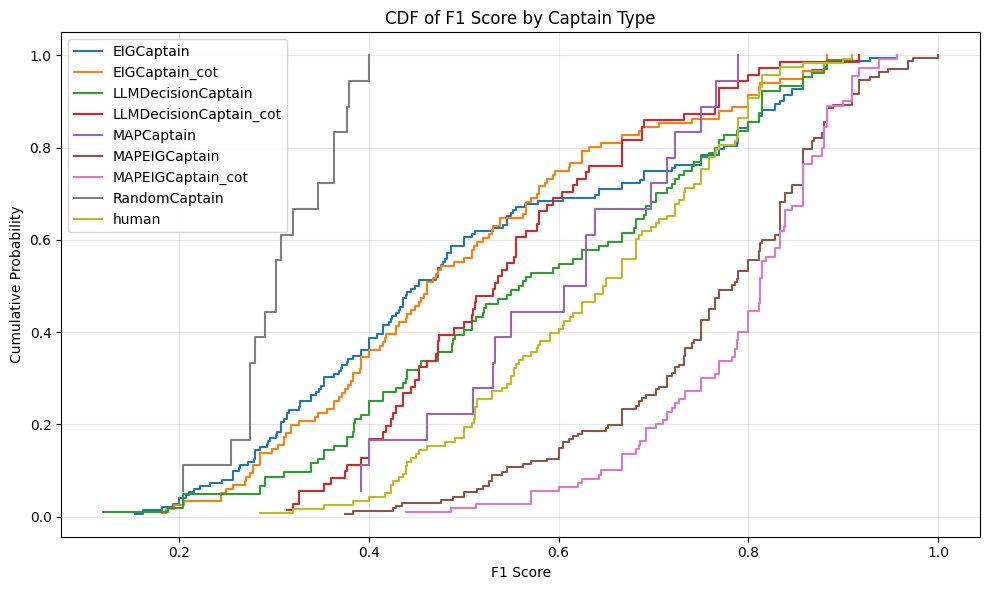

In [65]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for captain_type, group in combined_df.groupby('captain_type'):
    f1_scores = np.sort(group['f1_score'].dropna())
    cdf = np.arange(1, len(f1_scores) + 1) / len(f1_scores)
    plt.step(f1_scores, cdf, where='post', label=captain_type)

plt.xlabel('F1 Score')
plt.ylabel('Cumulative Probability')
plt.title('CDF of F1 Score by Captain Type')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'human'),
  Text(1, 0, 'EIGCaptain_cot'),
  Text(2, 0, 'EIGCaptain'),
  Text(3, 0, 'LLMDecisionCaptain_cot'),
  Text(4, 0, 'LLMDecisionCaptain'),
  Text(5, 0, 'MAPEIGCaptain_cot'),
  Text(6, 0, 'MAPEIGCaptain'),
  Text(7, 0, 'RandomCaptain'),
  Text(8, 0, 'MAPCaptain')])

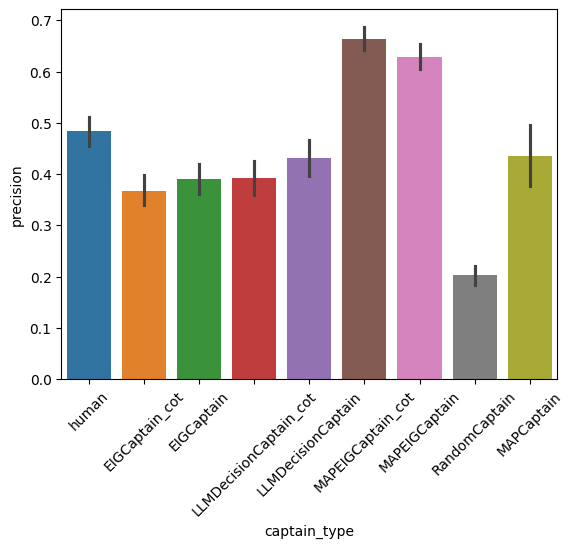

In [66]:
sns.barplot(data=combined_df, x="captain_type", y="precision", hue="captain_type")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'human'),
  Text(1, 0, 'EIGCaptain_cot'),
  Text(2, 0, 'EIGCaptain'),
  Text(3, 0, 'LLMDecisionCaptain_cot'),
  Text(4, 0, 'LLMDecisionCaptain'),
  Text(5, 0, 'MAPEIGCaptain_cot'),
  Text(6, 0, 'MAPEIGCaptain'),
  Text(7, 0, 'RandomCaptain'),
  Text(8, 0, 'MAPCaptain')])

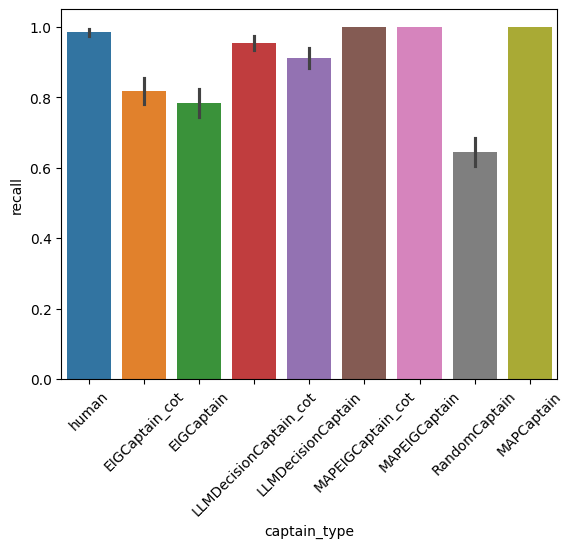

In [67]:
sns.barplot(data=combined_df, x="captain_type", y="recall", hue="captain_type")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'human'),
  Text(1, 0, 'EIGCaptain_cot'),
  Text(2, 0, 'EIGCaptain'),
  Text(3, 0, 'LLMDecisionCaptain_cot'),
  Text(4, 0, 'LLMDecisionCaptain'),
  Text(5, 0, 'MAPEIGCaptain_cot'),
  Text(6, 0, 'MAPEIGCaptain'),
  Text(7, 0, 'RandomCaptain'),
  Text(8, 0, 'MAPCaptain')])

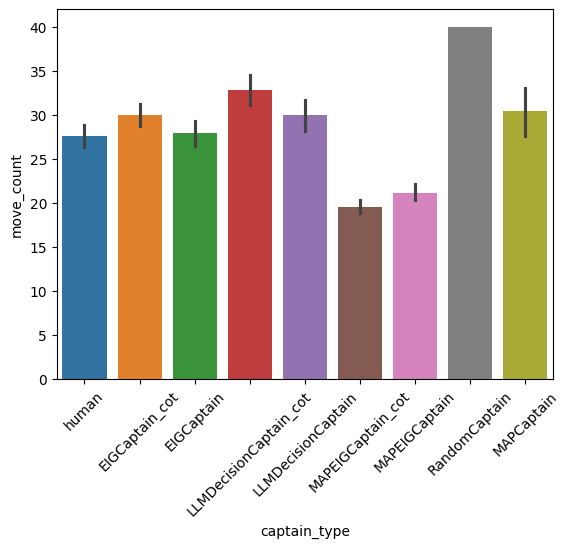

In [68]:
combined_df["move_count"] = combined_df["hits"] + combined_df["misses"]

sns.barplot(data=combined_df, x="captain_type", y="move_count", hue="captain_type")
plt.xticks(rotation=45)